<a href="https://colab.research.google.com/github/KKarthik2002/es335-24-fall-assignment-2_Gamet/blob/master/task_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Retina display
%config InlineBackend.figure_format = 'retina'

In [48]:
from einops import rearrange

In [5]:
# Read in a image from torchvision
img = torchvision.io.read_image("/content/virat.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


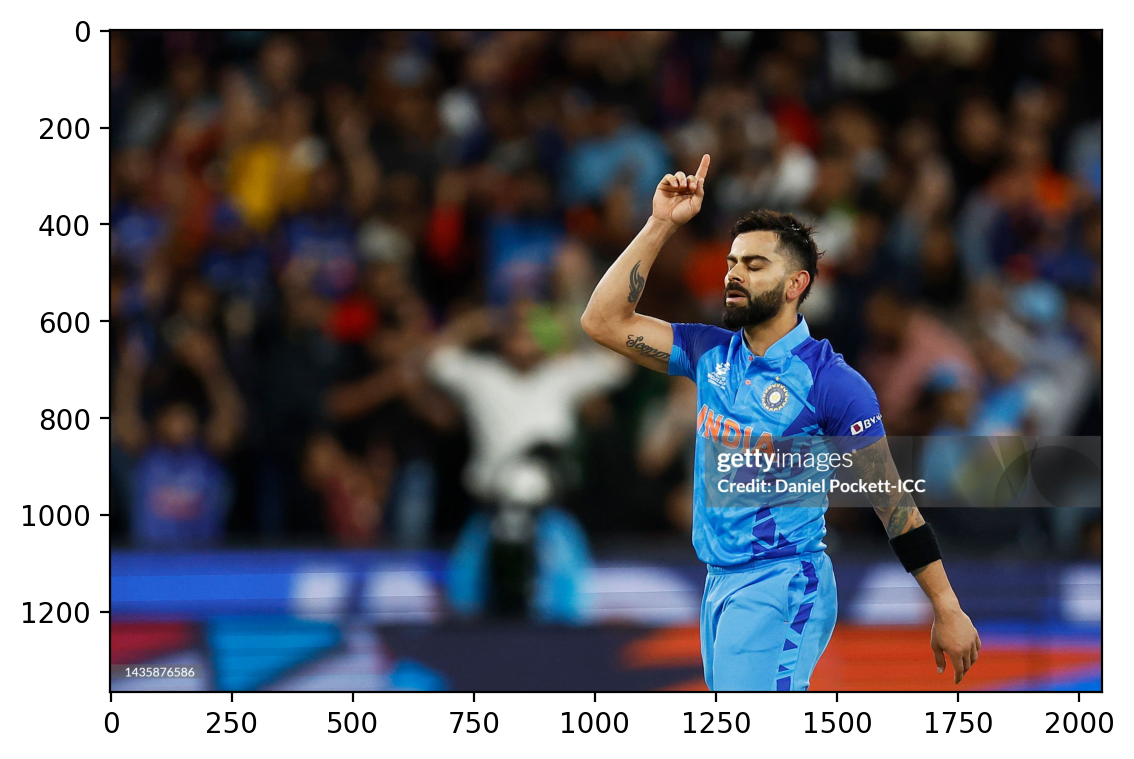

In [6]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [8]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled

(3, 1365, 2048)


tensor([[[0.1373, 0.1373, 0.1373,  ..., 0.1725, 0.1725, 0.1765],
         [0.1373, 0.1373, 0.1373,  ..., 0.1725, 0.1765, 0.1765],
         [0.1373, 0.1373, 0.1373,  ..., 0.1765, 0.1765, 0.1804],
         ...,
         [0.4353, 0.4353, 0.4392,  ..., 0.0000, 0.0000, 0.0039],
         [0.4549, 0.4510, 0.4471,  ..., 0.0000, 0.0000, 0.0039],
         [0.4627, 0.4627, 0.4549,  ..., 0.0000, 0.0000, 0.0039]],

        [[0.0706, 0.0706, 0.0706,  ..., 0.1176, 0.1176, 0.1216],
         [0.0706, 0.0706, 0.0706,  ..., 0.1176, 0.1216, 0.1216],
         [0.0706, 0.0706, 0.0706,  ..., 0.1216, 0.1216, 0.1255],
         ...,
         [0.4824, 0.4902, 0.4941,  ..., 0.4039, 0.4039, 0.4078],
         [0.5020, 0.5059, 0.5098,  ..., 0.4000, 0.4000, 0.4078],
         [0.5098, 0.5176, 0.5176,  ..., 0.4000, 0.4000, 0.4078]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.0667, 0.0667, 0.0706],
         [0.0392, 0.0392, 0.0392,  ..., 0.0667, 0.0706, 0.0706],
         [0.0392, 0.0392, 0.0392,  ..., 0.0784, 0.0706, 0.

In [9]:
img_scaled=img_scaled.to(device)

In [12]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 350,1200,300,300)
crop.shape

torch.Size([3, 300, 300])

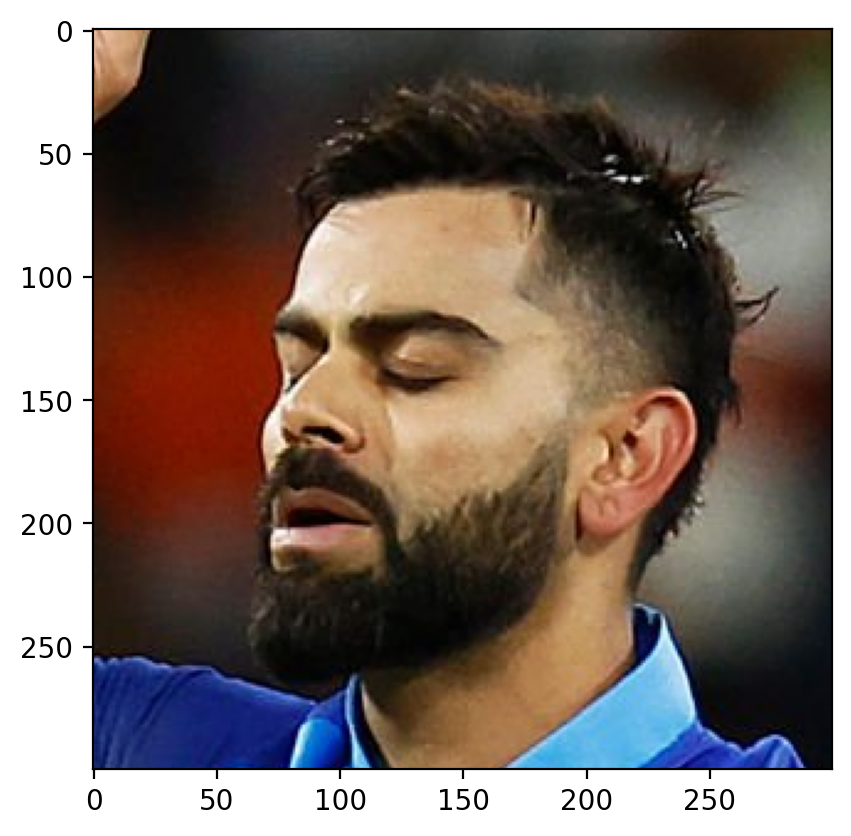

In [13]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
#Creating coordinate map of the cropped image
virat_X,virat_Y=create_coordinate_map(crop)
virat_X.shape,virat_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [16]:
from pickle import SHORT_BINUNICODE
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(virat_X.cpu())

# Scale the X coordinates
virat_X_scaled = scaler_X.transform(virat_X.cpu())

# Move the scaled X coordinates to the GPU
virat_X_scaled = torch.tensor(virat_X_scaled).to(device)

# Set to dtype float32
virat_X_scaled = virat_X_scaled.float()

In [17]:
# create RFF features
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
 #   from sklearn.kernel_approximation import RBFSampler
  rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
  X = X.cpu().numpy()
  X = rff.fit_transform(X)
  return torch.tensor(X, dtype=torch.float32).to(device)

In [37]:
X_rff = create_rff_features(virat_X_scaled,50000 , 0.008)

In [38]:
X_rff.shape

torch.Size([90000, 50000])

In [20]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [21]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [39]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net,0.005,X_rff,virat_Y,1500)

Epoch 0 loss: 0.139797
Epoch 100 loss: 0.018383
Epoch 200 loss: 0.007703
Epoch 300 loss: 0.003424
Epoch 400 loss: 0.001566
Epoch 500 loss: 0.000773
Epoch 600 loss: 0.000453
Epoch 700 loss: 0.000332
Epoch 800 loss: 0.000289
Epoch 900 loss: 0.000274
Epoch 1000 loss: 0.000269
Epoch 1100 loss: 0.000266
Epoch 1200 loss: 0.000264
Epoch 1300 loss: 0.000263
Epoch 1400 loss: 0.000262


0.00026078219525516033

In [40]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

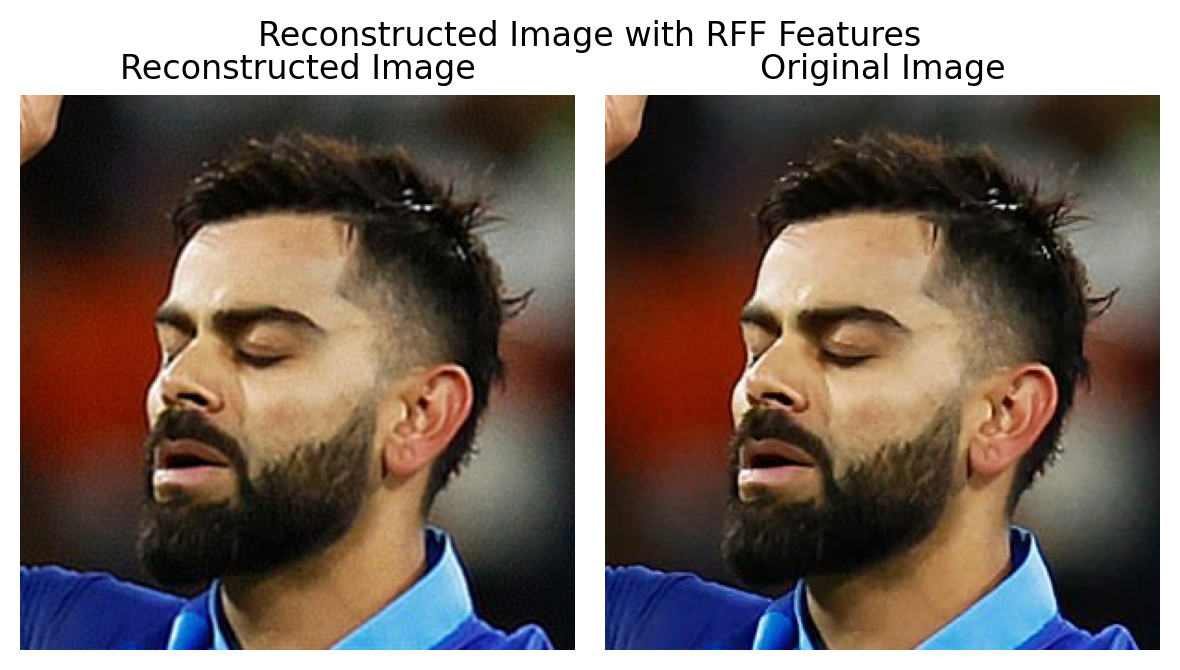

In [41]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [46]:
output=net(X_rff)
output = output.reshape(3,300,300)

In [49]:
def calculate_psnr(reference, output):
  """Calculates PSNR between two PyTorch tensors.

  Args:
    reference: PyTorch tensor representing the reference image.
    output: PyTorch tensor representing the output image.

  Returns:
    PSNR value.
  """

  mse = torch.nn.functional.mse_loss(reference, output, reduction='none').mean()
  max_val = 1.0
  psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
  return psnr.item()

psnr_value = calculate_psnr(crop,output)
print("PSNR:", psnr_value)

PSNR: 9.25746906143156
